In [1]:
!pip install -U tensorflow

In [2]:
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras

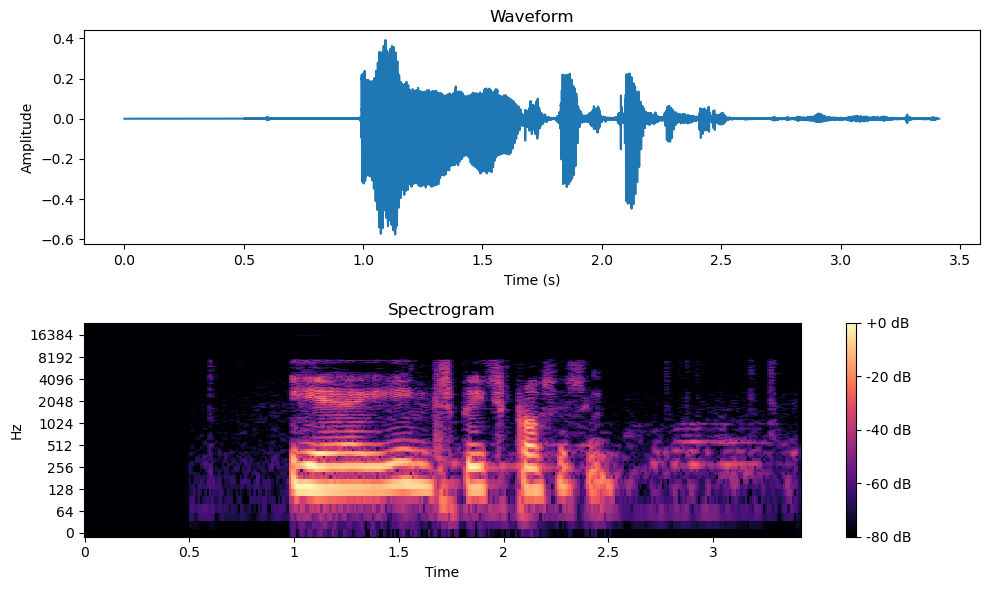

C:\Users\yenug\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 13, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 13, 64)         │        16,448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 13, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 13, 10)         │         1,290 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,906 (847.29 KB)

 Trainable params: 216,906 (847.29 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
import numpy as np
import librosa
import librosa.display
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, TimeDistributed, Dropout
import matplotlib.pyplot as plt

def prepare_data(audio_file):
    # Load the recorded speech signal
    y, sr = librosa.load(audio_file, sr=None)

    # Preprocessing
    # Short-Time Fourier Transform (STFT)
    D = np.abs(librosa.stft(y))

    # Mel-Frequency Cepstral Coefficients (MFCC)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Prepare input data for the LSTM model
    X = mfccs.T  # Transpose the MFCC matrix to match the shape expected by the LSTM model
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Add channel dimension

    return X

def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        Bidirectional(LSTM(units=128, return_sequences=True), input_shape=input_shape),
        TimeDistributed(Dense(units=64, activation='relu')),
        Dropout(0.2),
        Bidirectional(LSTM(units=64, return_sequences=True)),
        TimeDistributed(Dense(units=num_classes, activation='softmax'))
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def plot_signals(audio_file):
    # Load the recorded speech signal
    y, sr = librosa.load(audio_file, sr=None)

    # Plot the waveform
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(y)) / sr, y)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot the spectrogram
    plt.subplot(2, 1, 2)
    D = np.abs(librosa.stft(y))
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    plt.tight_layout()
    plt.show()

# Define the audio file path
audio_file = "lab@omkar.wav"

# Plot the signals
plot_signals(audio_file)

# Prepare data for LSTM model
X = prepare_data(audio_file)

# Define the number of classes (replace with actual number)
num_classes = 10

# Build LSTM model
model = build_lstm_model(input_shape=X.shape[1:], num_classes=num_classes)

# Display model summary
model.summary()

In [7]:
!pip install SpeechRecognition



  Obtaining dependency information for SpeechRecognition from https://files.pythonhosted.org/packages/9e/e9/edd24b7000e209f34b5f7d13daa05337a1c306b120c0b92bb24e4527d579/SpeechRecognition-3.10.3-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/32.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/32.8 MB 3.3 MB/s eta 0:00:10
   ---------------------------------------- 0.2/32.8 MB 3.0 MB/s eta 0:00:11
    --------------------------------------- 0.4/32.8 MB 3.4 MB/s eta 0:00:10
    --------------------------------------- 0.7/32.8 MB 3.9 MB/s eta 0:00:09
   - -------------------------------------- 1.0/32.8 MB 4.7 MB/s eta 0:00:07
   - -------------------------------------- 1.3/32.8 MB 5.0 MB/s eta 0:00:07
   - -------------------------------------- 1.3/32.8 MB 5.0 MB/s eta 0:00:07
   - -------------------------------------- 1.3/32.8 MB 5.0 MB/s eta 0:00:07
   - -------------------------------------- 1.3/32.8 MB 5.0 MB/s eta 0:00:07
   - --------

In [10]:
!pip install pyttsx3

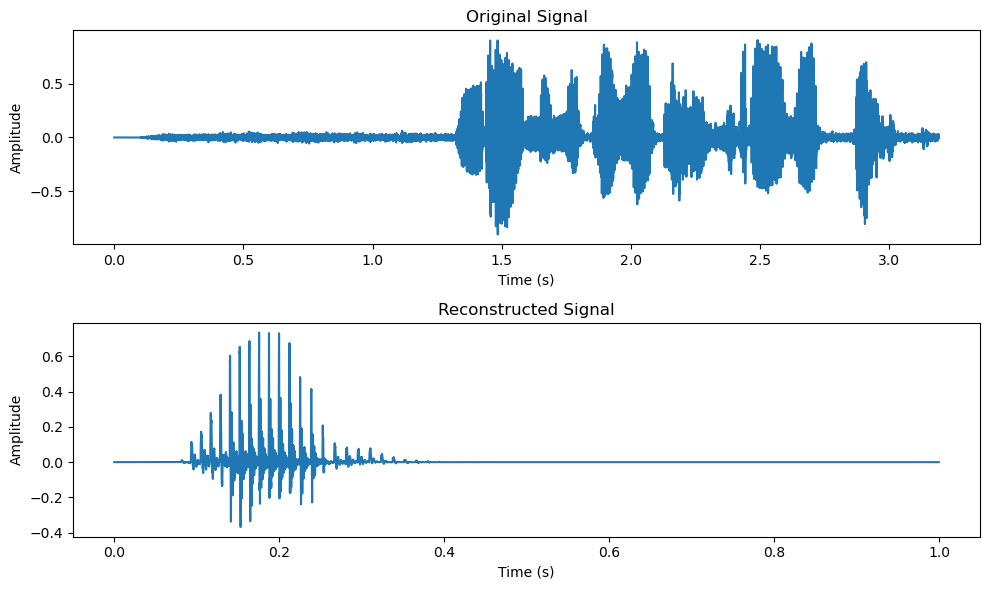

In [12]:
import os
import tempfile
import speech_recognition as sr
import pyttsx3
import matplotlib.pyplot as plt
import numpy as np
import librosa

# Get a temporary directory where you have write permissions
custom_temp_dir =  r"C:\Users\yenug\OneDrive\Desktop\speech processing\Lab8"

# Function to segment phonemes for a target word in transcription
def segment_phonemes(transcription, target_word):
    words = transcription.split()
    for word in words:
        if word.lower() == target_word.lower():
            return word

# Function to synthesize speech for a word using segmented phonemes
def synthesize_word(phonemes, output_file):
    engine = pyttsx3.init()
    engine.save_to_file(phonemes, output_file)
    engine.runAndWait()

# Transcribe the audio file
audio_file = "bhanumati_weds_rajat.wav"
recognizer = sr.Recognizer()
with sr.AudioFile(audio_file) as source:
    audio_data = recognizer.record(source)
transcription = recognizer.recognize_google(audio_data)

# Segment phonemes for the word "Bharat"
phonemes = segment_phonemes(transcription, "bharat")

# Synthesize speech for the word "Bharat"
output_file = os.path.join(custom_temp_dir, "bharat.wav")
synthesize_word(phonemes, output_file)

# Plot original and reconstructed signals
plt.figure(figsize=(10, 6))

# Original signal
plt.subplot(2, 1, 1)
plt.title('Original Signal')
audio_data_np, _ = librosa.load(audio_file, sr=source.SAMPLE_RATE)
plt.plot(np.linspace(0, len(audio_data_np) / source.SAMPLE_RATE, num=len(audio_data_np)), audio_data_np)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Reconstructed signal
reconstructed_audio_data, _ = librosa.load(output_file, sr=source.SAMPLE_RATE)
plt.subplot(2, 1, 2)
plt.title('Reconstructed Signal')
plt.plot(np.linspace(0, len(reconstructed_audio_data) / source.SAMPLE_RATE, num=len(reconstructed_audio_data)), reconstructed_audio_data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [13]:
import IPython.display as ipd 
ipd.display(ipd.Audio(r"bharat.wav"))
